<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# **Desafío 4:** *LSTM Bot QA*
## Procesamiento del Lenguaje Natural I
### Carrera de Especialización en Inteligencia Artificial - Cohorte 17
##### Docentes: Rodrigo Cárdenas / Nicolás  Vattuone
#### Autor: Alejandro Lloveras

### Consigna
- Construir un BOT para responder a preguntas del usuario (QA).
- Utilizar datos disponibles del challenge **ConvAI2** *(Conversational Intelligence Challenge 2)* de conversaciones en inglés.
- Preparar los embeddings para transformar los tokens de entrada en vectores
- Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados.
- Experimentar el funcionamiento del modelo. Realizar la inferencia de los modelos por separado de encoder y decoder.

### Datos
El objecto es utilizar datos disponibles del challenge **ConvAI2** *(Conversational Intelligence Challenge 2)* de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).

[Dataset](http://convai.io/data/)

### Inicialización

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
# Librerías estándar
import os
import re
import logging
import pickle
from pathlib import Path
from io import StringIO

# Manipulación y Análisis de Datos
import numpy as np
import pandas as pd

# PyTorch Data Handling
from torch.utils.data import Dataset, DataLoader

# Preprocesamiento de Texto
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.utils import pad_sequences

# División de Datos
from sklearn.model_selection import train_test_split

# Utilidades Keras/TensorFlow
import torch
import torch.nn as nn
import torch.nn.functional as F

# Construcción de Modelos y Capas Core (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding, Flatten, Input, LSTM, SimpleRNN
from tensorflow.keras.models import Model, Sequential

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [ ]:
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2025-04-24 03:17:10--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2025-04-24 03:17:10--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0.001s  

2025-04-24 03:17:11 (18.2 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2025-04-24 03:17:11--
Total wall clock time: 0.4s
Downloaded: 1 files, 23K in 0.001s (18.2 MB/s)


In [ ]:
def sequence_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=-1,keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1,keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    batch_acc = torch.zeros(batch_size)
    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    correct_results_sum = batch_acc.sum().float()
    acc = correct_results_sum / batch_size
    return acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch los va acumulando
            optimizer.zero_grad()

            output = model(train_encoder_input.to(device), train_decoder_input.to(device))

            # Computo el error de la salida comparando contra las etiquetas
            # por cada token en cada batch (sequence_loss)
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                loss += criterion(output[:, t, :], train_target[:, t, :])

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = sequence_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        #valid_encoder_input, valid_decoder_input, valid_target = iter(valid_loader).next()
        valid_encoder_input, valid_decoder_input, valid_target = next(iter(valid_loader))
        output = model(valid_encoder_input.to(device), valid_decoder_input.to(device))

        epoch_valid_loss = 0
        for t in range(train_decoder_input.shape[1]):
                epoch_valid_loss += criterion(output[:, t, :], valid_target[:, t, :])
        epoch_valid_loss = epoch_valid_loss.item()

        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = sequence_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

In [ ]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        # Inicia el bucle de entrenamiento por batch
        for train_encoder_input, train_decoder_input, train_target in train_loader:
            optimizer.zero_grad()

            output = model(train_encoder_input.to(device), train_decoder_input.to(device))

            # Computo el error del batch - INEFICIENTE BUCLE t
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                loss += criterion(output[:, t, :], train_target[:, t, :])

            epoch_train_loss += loss.item() # Acumula pérdida por batch

            loss.backward()
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = sequence_acc(output, train_target)
            epoch_train_accuracy += accuracy.item() # Acumula accuracy por batch

        # Calcula la media de metrics por epoca
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación - ¡¡SOLO UN BATCH!!
        #valid_encoder_input, valid_decoder_input, valid_target = iter(valid_loader).next()
        valid_encoder_input, valid_decoder_input, valid_target = next(iter(valid_loader)) # <= PROBLEMA MAYOR

        # Falta with torch.no_grad(): y model.eval()
        output = model(valid_encoder_input.to(device), valid_decoder_input.to(device))

        epoch_valid_loss = 0 # Acumula pérdida por batch
        for t in range(train_decoder_input.shape[1]): # INEFICIENTE BUCLE t, y usa shape[1] de train_decoder_input
                epoch_valid_loss += criterion(output[:, t, :], valid_target[:, t, :])
        epoch_valid_loss = epoch_valid_loss.item() # Solo tiene la pérdida del ULTIMO batch procesado (solo 1 batch)

        valid_loss.append(epoch_valid_loss) # Solo añade la pérdida de UN batch

        # Calculo el accuracy de la epoch - ¡¡SOLO UN BATCH!!
        epoch_valid_accuracy = sequence_acc(output, valid_target).item() # Solo tiene el accuracy de UN batch
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Guardado de resultados

In [ ]:
# Definimos una ruta para guardar los pesos
filepath = 'model_weights.pth'

# Guardamos el diccionario de estados
torch.save(model.state_dict(), filepath)

print(f"✅ Pesos del modelo guardados en {filepath}")

✅ Pesos del modelo guardados en model_weights.pth


In [ ]:
# Definimos la ruta para guardar el historial en un archivo CSV
history_filepath = 'training_history.csv'

# Creamos un DataFrame de pandas
df_history = pd.DataFrame(history1)

# Guardamos el DataFrame en un archivo CSV
df_history.to_csv(history_filepath, index=False)

print(f"✅ Historial de entrenamiento guardado en {history_filepath}")

Training history saved to training_history.csv


## 5. Inferencia
Se experimenta el funcionamiento del modelo. Se realiza la inferencia de los modelos por separado de encoder y decoder.

In [ ]:
# Cargamos los pesos del modelo guardados
model_weights_path = 'model_weights.pth'
model.load_state_dict(torch.load(model_weights_path))

print(f"✅ Pesos del modelo cargados desde {model_weights_path}")

Model weights loaded from model_weights (2).pth


## 1. Descarga del dataset

In [8]:
# Descargar la carpeta de dataset
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("✅ El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 72.4MB/s]


In [9]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [10]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [11]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("▪ Cantidad de rows utilizadas:", len(input_sentences))

▪ Cantidad de rows utilizadas: 6033


In [12]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

## 2. Preprocesamiento

In [13]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

### 2.1 Datos de Entrada:
Calculo de `word2idx_inputs`, `max_input_len`

In [14]:
!pip install --no-deps torch_helpers
!pip install moleskin boltons termcolor

INFO: pip is looking at multiple versions of moleskin to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of moleskin to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
ERROR: Cannot install moleskin==0.0.0, moleskin==0.0.1, moleskin==0.0.2, moleskin==0.0.3, moleskin==0.0.4, moleskin==0.0.5, moleskin==0.0.6, moleskin==0.0.7, moleskin==0.0.8, moleskin==0.1.0, moleskin==0.1.1, moleskin==1.0.0, moleskin==1.1.0, moleskin==1.1.1, moleskin==1.2.0, moleskin==1.3.0, moleskin==1.3.1, moleskin==1.4.0, moleskin==1.5.0 and moleskin==1.5.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    mole

In [15]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("▪ Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("▪ Oración de entrada más larga:", max_input_len)

▪ Palabras en el vocabulario: 1799
▪ Oración de entrada más larga: 9


### 2.2 Datos de Salida:
Calculo de `word2idx_outputs`, `max_out_len`, `num_words_output`

In [16]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("▪ Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("▪ Oración de salida más larga:", max_out_len)

▪ Palabras en el vocabulario: 1806
▪ Oración de salida más larga: 10


### 2.3 Secuencias:
Calculo de `encoder_input_sequences`, `decoder_output_sequences`, `decoder_targets`

In [17]:
print("▪ Cantidad de filas del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("▪ Forma de 'encoder_input_sequences':", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("▪ Forma de 'decoder_input_sequences':", decoder_input_sequences.shape)

▪ Cantidad de filas del dataset: 6033
▪ Forma de 'encoder_input_sequences': (6033, 9)
▪ Forma de 'decoder_input_sequences': (6033, 10)


In [18]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("▪ Forma de 'decoder_output_sequences':", decoder_output_sequences.shape)


▪ Forma de 'decoder_output_sequences': (6033, 10)


In [19]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.decoder_outputs = F.one_hot(torch.from_numpy(decoder_output).to(torch.int64), num_classes=num_words_output).float()

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("▪ Tamaño de entrada del Encoder:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("▪ Tamaño de entrada del Decoder:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[2]
print("▪ Dimensiones de salida: ", output_dim)

▪ Tamaño de entrada del Encoder: 9
▪ Tamaño de entrada del Decoder: 10
▪ Dimensiones de salida:  1807


Ahora, se realiza el split del dataset

In [20]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("▪ Tamaño del conjunto de entrenamiento:", len(train_set))
print("▪ Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=False)

▪ Tamaño del conjunto de entrenamiento: 4827
▪ Tamaño del conjunto de validacion: 1206


## 3. Preparar los embeddings
Se utilizan los embeddings de Glove (de 50 dim) para transformar los tokens de entrada en vectores

In [21]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("✅ Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download
From (redirected): https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download&confirm=t&uuid=bd3ba1e1-f1a9-405c-917a-57038554f8f7
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:07<00:00, 73.9MB/s]


In [22]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

# class FasttextEmbeddings(WordsEmbeddings):
#     WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
#     PKL_PATH = 'fasttext.pkl'
#     N_FEATURES = 300
#     WORD_MAX_SIZE = 60

In [23]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [24]:
# Crear la Embedding matrix de las secuencias en ingles

print('Preparando la matriz de embedding...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('▪ Cantidad de embeddings de palabras nulas:', np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("▪ Tamaño del vocabulario: ", nb_words)

Preparando la matriz de embedding...
▪ Cantidad de embeddings de palabras nulas: 38
▪ Tamaño del vocabulario:  1799


In [25]:
# Dimensión de los embeddings de la secuencia en ingles
embedding_matrix.shape

(1799, 50)

## 4. Entrenamiento del modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [ ]:
lstm_size = 128
num_layers = 1

class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim

        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)

        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)

        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random
            # para ver en cada vuelta que técnica se aplica
            #input = top1

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs

encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

In [ ]:
# Get the tuple for the first sample
first_sample_data = data_set[0]

# Extract the encoder and decoder inputs
encoder_input_sample = first_sample_data[0]
decoder_input_sample = first_sample_data[1]

# Add a batch dimension (summary usually expects a batch)
# Use .to(device) if your model is on CUDA
encoder_input_sample = encoder_input_sample.unsqueeze(0).to(device)
decoder_input_sample = decoder_input_sample.unsqueeze(0).to(device)

# Pass the input tuple to summary
summary(model, input_data=(encoder_input_sample, decoder_input_sample))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 10, 1807]             --
├─Encoder: 1-1                           [1, 1, 128]               --
│    └─Embedding: 2-1                    [1, 9, 50]                (89,950)
│    └─LSTM: 2-2                         [1, 9, 128]               92,160
├─Decoder: 1-2                           [1, 1807]                 --
│    └─Embedding: 2-3                    [1, 1, 50]                90,350
│    └─LSTM: 2-4                         [1, 1, 128]               92,160
│    └─Linear: 2-5                       [1, 1807]                 233,103
│    └─Softmax: 2-6                      [1, 1807]                 --
├─Decoder: 1-3                           [1, 1807]                 (recursive)
│    └─Embedding: 2-7                    [1, 1, 50]                (recursive)
│    └─LSTM: 2-8                         [1, 1, 128]               (recursive)
│    └─Linear: 2-9                 

In [28]:
history1 = train(model,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=1000
                )

Epoch: 1/1000 - Train loss 70.501 - Train accuracy 0.499 - Valid Loss 69.810 - Valid accuracy 0.520
Epoch: 2/1000 - Train loss 69.802 - Train accuracy 0.520 - Valid Loss 69.807 - Valid accuracy 0.520
Epoch: 3/1000 - Train loss 69.794 - Train accuracy 0.521 - Valid Loss 69.794 - Valid accuracy 0.521
Epoch: 4/1000 - Train loss 69.793 - Train accuracy 0.521 - Valid Loss 69.795 - Valid accuracy 0.521
Epoch: 5/1000 - Train loss 69.786 - Train accuracy 0.522 - Valid Loss 69.785 - Valid accuracy 0.522
Epoch: 6/1000 - Train loss 69.780 - Train accuracy 0.523 - Valid Loss 69.784 - Valid accuracy 0.522
Epoch: 7/1000 - Train loss 69.775 - Train accuracy 0.523 - Valid Loss 69.775 - Valid accuracy 0.523
Epoch: 8/1000 - Train loss 69.771 - Train accuracy 0.523 - Valid Loss 69.771 - Valid accuracy 0.523
Epoch: 9/1000 - Train loss 69.765 - Train accuracy 0.524 - Valid Loss 69.773 - Valid accuracy 0.523
Epoch: 10/1000 - Train loss 69.768 - Train accuracy 0.524 - Valid Loss 69.770 - Valid accuracy 0.523

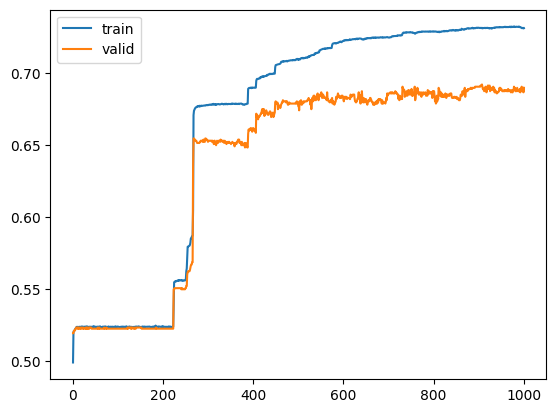

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

### Guardado de resultados

In [ ]:
# Definimos una ruta para guardar los pesos
filepath = 'model_weights.pth'

# Guardamos el diccionario de estados
torch.save(model.state_dict(), filepath)

print(f"✅ Pesos del modelo guardados en {filepath}")

✅ Pesos del modelo guardados en model_weights.pth


In [ ]:
# Definimos la ruta para guardar el historial en un archivo CSV
history_filepath = 'training_history.csv'

# Creamos un DataFrame de pandas
df_history = pd.DataFrame(history1)

# Guardamos el DataFrame en un archivo CSV
df_history.to_csv(history_filepath, index=False)

print(f"✅ Historial de entrenamiento guardado en {history_filepath}")

✅ Historial de entrenamiento guardado en training_history.csv


## 5. Inferencia
Se experimenta el funcionamiento del modelo. Se realiza la inferencia de los modelos por separado de encoder y decoder.

In [ ]:
# Cargamos los pesos del modelo guardados
model_weights_path = 'model_weights.pth'
model.load_state_dict(torch.load(model_weights_path))

print(f"✅ Pesos del modelo cargados desde {model_weights_path}")

✅ Pesos del modelo cargados desde model_weights.pth


In [37]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [38]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

### Test 1

In [39]:
input_test = "My mother say hi."
print('▪ Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("▪ Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("▪ Padding del vector:", encoder_sequence_test)

# ENCODER STEP
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

# Se obtiene la salida del encoder (el estado oculto para el decoder)
prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

# Se inicializa la secuencia de entrada al decoder como "<sos>"
target_seq = np.zeros((1, 1))
target_seq[0, 0] = word2idx_outputs['<sos>']
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

# Se obtiene la primera palabra de la secuencia de salida del decoder
output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

print("\n1. Etapa Encoder:")
top1 = output.argmax(1).view(-1, 1)
idx = int(top1.cpu())
print("▪ Index/token de salida:", idx)

word = idx2word_target[idx]
print("▪ Palabra de salida:", word)

print("\n2. Etapa Decoder:")

integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

translation = translate_sentence(encoder_sequence_test)
print('▪ Response:', translation)

▪ Input: My mother say hi.
▪ Representacion en vector de tokens de ids [36, 356, 113, 11]
▪ Padding del vector: [[  0   0   0   0   0  36 356 113  11]]

1. Etapa Encoder:
▪ Index/token de salida: 3
▪ Palabra de salida: i

2. Etapa Decoder:
▪ Response: i am a vegan


### Test 2

In [40]:
input_test = "Your mother say bye."
print('▪ Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("▪ Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("▪ Padding del vector:", encoder_sequence_test)

# ENCODER STEP
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

# Se obtiene la salida del encoder (el estado oculto para el decoder)
prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

# Se inicializa la secuencia de entrada al decoder como "<sos>"
target_seq = np.zeros((1, 1))
target_seq[0, 0] = word2idx_outputs['<sos>']
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

# Se obtiene la primera palabra de la secuencia de salida del decoder
output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

print("\n1. Etapa Encoder:")
top1 = output.argmax(1).view(-1, 1)
idx = int(top1.cpu())
print("▪ Index/token de salida:", idx)

word = idx2word_target[idx]
print("▪ Palabra de salida:", word)

print("\n2. Etapa Decoder:")

integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

translation = translate_sentence(encoder_sequence_test)
print('▪ Response:', translation)

▪ Input: Your mother say bye.
▪ Representacion en vector de tokens de ids [21, 356, 113, 58]
▪ Padding del vector: [[  0   0   0   0   0  21 356 113  58]]

1. Etapa Encoder:
▪ Index/token de salida: 3
▪ Palabra de salida: i

2. Etapa Decoder:
▪ Response: i am a vegan


### Test 3

In [41]:
input_test = "What do you want from me?"
print('▪ Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("▪ Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("▪ Padding del vector:", encoder_sequence_test)

# ENCODER STEP
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

# Se obtiene la salida del encoder (el estado oculto para el decoder)
prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

# Se inicializa la secuencia de entrada al decoder como "<sos>"
target_seq = np.zeros((1, 1))
target_seq[0, 0] = word2idx_outputs['<sos>']
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

# Se obtiene la primera palabra de la secuencia de salida del decoder
output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

print("\n1. Etapa Encoder:")
top1 = output.argmax(1).view(-1, 1)
idx = int(top1.cpu())
print("▪ Index/token de salida:", idx)

word = idx2word_target[idx]
print("▪ Palabra de salida:", word)

print("\n2. Etapa Decoder:")

integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

translation = translate_sentence(encoder_sequence_test)
print('▪ Response:', translation)

▪ Input: What do you want from me?
▪ Representacion en vector de tokens de ids [4, 3, 2, 92, 39, 35]
▪ Padding del vector: [[ 0  0  0  4  3  2 92 39 35]]

1. Etapa Encoder:
▪ Index/token de salida: 3
▪ Palabra de salida: i

2. Etapa Decoder:
▪ Response: i am a vegan


### Test 4

In [42]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('▪ Input:', input_sentences[i])
print('▪ Response:', translation)

▪ Input: my teek hu
▪ Response: i am a vegan


In [43]:
for n in range(20):
  i = np.random.choice(len(input_sentences))
  input_seq = encoder_input_sequences[i:i+1]
  encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
  translation = translate_sentence(encoder_sequence_test_tensor)
  print('▪ Input:', input_sentences[i])
  print('▪ Response:', translation,"\n")

▪ Input: so what 
▪ Response: i am a vegan 

▪ Input: do you have any pets 
▪ Response: i am a vegan 

▪ Input: you ask me my favorite color
▪ Response: i am a vegan 

▪ Input: what is your favorite game 
▪ Response: i am a vegan 

▪ Input: i take photos of many things
▪ Response: i am a vegan 

▪ Input: me to
▪ Response: i am a vegan 

▪ Input: yes i m do you like bees 
▪ Response: i am a vegan 

▪ Input: what do you do for a living 
▪ Response: i am a vegan 

▪ Input: what is your favorite book 
▪ Response: i am a vegan 

▪ Input: ok
▪ Response: i am a vegan 

▪ Input: hi how are you today
▪ Response: i am a vegan 

▪ Input: nice
▪ Response: i am a vegan 

▪ Input: what do you do for a living 
▪ Response: i am a vegan 

▪ Input: where it is
▪ Response: i am a vegan 

▪ Input: what do you do for a living 
▪ Response: i am a vegan 

▪ Input: what do you do for a living 
▪ Response: i am a vegan 

▪ Input: currently nthg
▪ Response: i am a vegan 

▪ Input: oh i see so you are a girl 
▪ 